In [0]:
%matplotlib inline

# Multi layer perceptron from scratch - MNIST dataset

A neural network needs a few building blocks

- Dense layer - a fully-connected layer, $f(X)=W \cdot X + \vec{b}$
- Activation function to introduce non-linearity: ReLU layer, Leaky_ReLU, TanH(Hyperbolic tangent function), Sigmoid are some examples of activation functions
- Loss function (crossentropy in case of multi-class classification problem)
- Backprop algorithm - a stochastic gradient descent with backpropageted gradients

Let's approach them one at a time.

Let's start by importing some libraires required for creating our neural network.

In [0]:
from __future__ import print_function
import numpy as np ## For numerical python
np.random.seed(42)

Every layer will have a forward pass and backpass implementation. Let's create a main class layer which can do a forward pass .forward() and Backward pass .backward().

In [0]:
class Layer:
    """
    A building block. Each layer is capable of performing two things:

    - Process input to get output:           output = layer.forward(input)
    
    - Propagate gradients through itself:    grad_input = layer.backward(input, grad_output)
    
    Some layers also have learnable parameters which they update during layer.backward.
    """
    def __init__(self):
        """Here we can initialize layer parameters (if any) and auxiliary stuff."""
        # A dummy layer does nothing
        pass
    
    def forward(self, input):
        """
        Takes input data of shape [batch, input_units], returns output data [batch, output_units]
        """
        # A dummy layer just returns whatever it gets as input.
        return input

    def backward(self, input, grad_output):
        """
        Performs a backpropagation step through the layer, with respect to the given input.
        
        To compute loss gradients w.r.t input, we need to apply chain rule (backprop):
        
        d loss / d x  = (d loss / d layer) * (d layer / d x)
        
        Luckily, we already receive d loss / d layer as input, so you only need to multiply it by d layer / d x.
        
        If our layer has parameters (e.g. dense layer), we also need to update them here using d loss / d layer
        """
        # The gradient of a dummy layer is precisely grad_output, but we'll write it more explicitly
        num_units = input.shape[1]
        
        d_layer_d_input = np.eye(num_units)
        
        return np.dot(grad_output, d_layer_d_input) # chain rule

### Nonlinearity ReLU layer

This is the simplest layer you can get: it simply applies a nonlinearity to each element of your network.

In [0]:
class ReLU(Layer):
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        pass
    
    def forward(self, input):
        """Apply elementwise ReLU to [batch, input_units] matrix"""
        relu_forward = np.maximum(0,input)
        return relu_forward
    
    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. ReLU input"""
        relu_grad = input > 0
        return grad_output*relu_grad 

### Nonlinearity Leaky ReLU layer


In [0]:
class LeakyReLU(Layer):
    def __init__(self):
        """Leaky ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        pass
    
    def forward(self, input):
        """Apply elementwise Leaky ReLU to [batch, input_units] matrix"""
        relu_forward = np.where(input > 0, input, input * 0.01)
        return relu_forward
    
    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. Leaky ReLU input"""
        relu_grad = np.where(input > 0, 1.0, 0.01)
        return grad_output*relu_grad 

### Nonlinearity TanH

In [0]:
class TanH(Layer):
    def __init__(self):
        """Hyperbolic tangent layer"""
        pass
    
    def forward(self, input):
        """Apply elementwise Hyperbolic Tangent to [batch, input_units] matrix"""
        tanh_forward = np.tanh(input)
        return tanh_forward
    
    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. Hyperbolic Tangent input"""
        tanh_grad = 1.0-np.tanh(input)*np.tanh(input)
        return grad_output*tanh_grad 

### Nonlinearity Sigmoid

In [0]:
class Sigmoid(Layer):
    def __init__(self):
        """Sigmoid layer"""
        pass

    def sigmoid(self, x):
        return 1/(1 + np.exp(-x)) 

    def forward(self, input):
        """Apply elementwise Sigmoid function to [batch, input_units] matrix"""
        sigmoid_forward = self.sigmoid(input)
        return sigmoid_forward
    
    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. Sigmoid input"""
        sigmoid_grad = self.sigmoid(input)*(1.0-self.sigmoid(input))
        return grad_output*sigmoid_grad 

In [0]:
from enum import Enum, unique

@unique
class ActivationFunction(Enum):
    RELU = 1
    LEAKY_RELU = 2
    TANH = 3 # Hyperbolic tangent function
    SIGMOID = 4


def get_activation_function(activation):
    if activation == ActivationFunction.RELU:
        return ReLU()
    elif activation == ActivationFunction.LEAKY_RELU:
        return LeakyReLU()
    elif activation == ActivationFunction.TANH:
        return TanH()
    elif activation == ActivationFunction.SIGMOID:
        return Sigmoid()

### Dense layer

Now let's build something more complicated. Unlike nonlinearity, a dense layer actually has something to learn.

A dense layer applies affine transformation. In a vectorized form, it can be described as:
$$f(X)= W \cdot X + \vec b $$

Where 
* X is an object-feature matrix of shape [batch_size, num_features],
* W is a weight matrix [num_features, num_outputs] 
* and b is a vector of num_outputs biases.

Both W and b are initialized during layer creation and updated each time backward is called. Note that we are using **Xavier initialization** which is a trick to train our model to converge faster [read more](http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization). Instead of initializing our weights with small numbers which are distributed randomly we initialize our weights with mean zero and variance of 2/(number of inputs + number of outputs)

In [0]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        """
        A dense layer is a layer which performs a learned affine transformation:
        f(x) = <W*x> + b
        """
        self.learning_rate = learning_rate
        self.weights = np.random.normal(loc=0.0, 
                                        scale = np.sqrt(2/(input_units+output_units)), 
                                        size = (input_units,output_units))
        self.biases = np.zeros(output_units)
        
    def forward(self,input):
        """
        Perform an affine transformation:
        f(x) = <W*x> + b
        
        input shape: [batch, input_units]
        output shape: [batch, output units]
        """
        return np.dot(input,self.weights) + self.biases
    
    def backward(self,input,grad_output):
        # compute d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed
        grad_input = np.dot(grad_output, self.weights.T)
        
        # compute gradient w.r.t. weights and biases
        grad_weights = np.dot(input.T, grad_output)
        grad_biases = grad_output.mean(axis=0)*input.shape[0]
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        
        # Here we perform a stochastic gradient descent step. 
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input

### The loss function

Since we want to predict probabilities, it would be logical for us to define softmax nonlinearity on top of our network and compute loss given predicted probabilities. However, there is a better way to do so.

If we write down the expression for crossentropy as a function of softmax logits (a), you'll see:

$$ loss = - log \space {e^{a_{correct}} \over {\underset i \sum e^{a_i} } } $$

If we take a closer look, we'll see that it can be rewritten as:

$$ loss = - a_{correct} + log {\underset i \sum e^{a_i} } $$

It's called Log-softmax and it's better than naive log(softmax(a)) in all aspects:
* Better numerical stability
* Easier to get derivative right
* Marginally faster to compute

So why not just use log-softmax throughout our computation and never actually bother to estimate probabilities.

In [0]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy from logits[batch,n_classes] and ids of correct answers"""
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

### Full network

Now let's combine what we've just built into a working neural network. We are going to use MNIST data of handwritten digit for our example. Fortunately, Keras already have it in the numpy array format, so let's import it!.

Using TensorFlow backend.


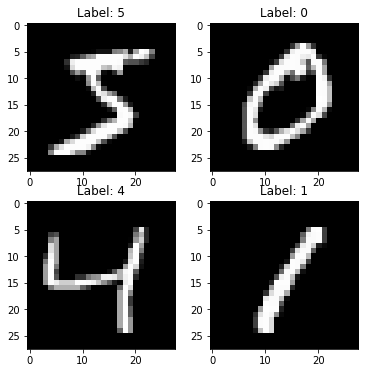

In [11]:
import keras
import matplotlib.pyplot as plt
%matplotlib inline

def load_dataset(flatten=False):
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

    # normalize x
    X_train = X_train.astype(float) / 255.
    X_test = X_test.astype(float) / 255.

    if flatten:
        X_train = X_train.reshape([X_train.shape[0], -1])
        X_test = X_test.reshape([X_test.shape[0], -1])

    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_dataset(flatten=True)

## Let's look at some example
plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

We'll define network as a list of layers, each applied on top of previous one. In this setting, computing predictions and training becomes trivial.

In [0]:
network = []
network.append(Dense(X_train.shape[1],100))
network.append(ReLU())
network.append(Dense(100,200))
network.append(ReLU())
network.append(Dense(200,10))

In [0]:
def forward(network, X):
    """
    Compute activations of all network layers by applying them sequentially.
    Return a list of activations for each layer. 
    """
    activations = []
    input = X

    # Looping through each layer
    for l in network:
        activations.append(l.forward(input))
        # Updating input to last layer output
        input = activations[-1]
    
    assert len(activations) == len(network)
    return activations

def predict(network,X):
    """
    Compute network predictions. Returning indices of largest Logit probability
    """
    logits = forward(network,X)[-1]
    return logits.argmax(axis=-1)

def train(network,X,y):
    """
    Train our network on a given batch of X and y.
    We first need to run forward to get all layer activations.
    Then we can run layer.backward going from last to first layer.
    After we have called backward for all layers, all Dense layers have already made one gradient step.
    """
    
    # Get the layer activations
    layer_activations = forward(network,X)
    layer_inputs = [X]+layer_activations  #layer_input[i] is an input for network[i]
    logits = layer_activations[-1]
    
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    
    # Propagate gradients through the network
    # Reverse propogation as this is backprop
    for layer_index in range(len(network))[::-1]:
        layer = network[layer_index]
        
        loss_grad = layer.backward(layer_inputs[layer_index],loss_grad) #grad w.r.t. input, also weight updates
        
    return np.mean(loss)

### Training loop

We split data into minibatches, feed each such minibatch into the network and update weights. This training method is called a mini-batch stochastic gradient descent.

In [0]:
from tqdm import trange
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [0]:
def get_network(input_units, output_units, learning_rate=0.1, epochs=25, dense_output_units=[100, 200], activation_function=ActivationFunction.RELU, print_network=False):
    if print_network:
        print('\tNETWORK: Multi layer perceptron')
    network = []
    network.append(Dense(input_units, dense_output_units[0], learning_rate))
    if print_network:
        print('\t\tDense(input_units={}, output_units={}, learning_rate={})'.format(input_units, dense_output_units[0], learning_rate))
    network.append(get_activation_function(activation_function))
    if print_network:
        print('\t\t{}()'.format(activation_function.name))
    
    for i, _ in enumerate(dense_output_units):
      if i == len(dense_output_units) - 1:
        break
      network.append(Dense(dense_output_units[i], dense_output_units[i+1], learning_rate))
      if print_network:
          print('\t\tDense(input_units={}, output_units={}, learning_rate={})'.format(dense_output_units[i], dense_output_units[i+1], learning_rate))
      network.append(get_activation_function(activation_function))
      if print_network:
          print('\t\t{}()'.format(activation_function.name))
    
    network.append(Dense(dense_output_units[-1], output_units))
    if print_network:
        print('\t\tDense(input_units={}, output_units={}, learning_rate={})'.format(dense_output_units[-1], output_units, learning_rate))

    return network

In [0]:
from IPython.display import clear_output
from time import time

def training_loop(network, input_units, output_units, learning_rate=0.1, epochs=25, dense_output_units=[100, 200], batchsize=32, shuffle=True):
    if len(dense_output_units) < 2:
      return

    epoch_start = time()
    train_acc_list = []
    test_acc_list = []
    epoch_time_list = []

    for epoch in range(epochs):

        for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=batchsize,shuffle=shuffle):
            train(network,x_batch,y_batch)
        
        train_acc_list.append(np.mean(predict(network,X_train)==y_train))
        test_acc_list.append(np.mean(predict(network,X_test)==y_test))
        
        clear_output()
        print("Epoch", epoch)
        print("Training accuracy: {:.2f}%".format(train_acc_list[-1]*100))
        print("Test accuracy: {:.2f}%".format(test_acc_list[-1]*100))
        epoch_time = time() - epoch_start
        epoch_time_list.append(epoch_time)
        print("Epoch's processing time: {:.2f} seconds".format(epoch_time))
        plt.plot(train_acc_list, label='train accuracy')
        plt.plot(test_acc_list, label='test accuracy')
        plt.legend(loc='best')
        plt.grid()
        plt.show()
    
    return train_acc_list, test_acc_list, epoch_time_list

## Testing different dense layers

* Using **2 dense layers** with learning_rate=0.1, activation function = RELU, minibatches with batchsize=32, shuffle=True

* Using **3 dense layers** with learning_rate=0.1, activation function = RELU, minibatches with batchsize=32, shuffle=True

* Using **4 dense layers** with learning_rate=0.1, activation function = RELU, minibatches with batchsize=32, shuffle=True

* Using **5 dense layers** with learning_rate=0.1, activation function = RELU, minibatches with batchsize=32, shuffle=True

In [0]:
test_accuracy_list = []

In [0]:
from time import time
import numpy as np

def mlp_training(network, input_units, output_units, learning_rate, epochs, dense_output_units, batchsize, shuffle):
    training_start = time()
    train_acc_list, test_acc_list, epoch_time_list = training_loop(network, input_units=input_units, output_units=output_units, learning_rate=learning_rate, epochs=epochs, dense_output_units=dense_output_units, batchsize=batchsize, shuffle=shuffle)
    print("Total time: {} seconds".format(time() - training_start))

    labels = ['epoch {}'.format(str(i).zfill(3)) for i in range(epochs)]

    train_acc_np = np.asarray(train_acc_list)
    print("\nTraining accuracy list: {}".format(train_acc_np))
    print("Training accuracy (Mean +/- Std): %0.2f (+/- %0.2f)" % (train_acc_np.mean()*100, train_acc_np.std() * 2))
    # Plot horizontal bar
    values = [v * 100 for v in train_acc_list]
    plot_horizontal_bar(labels, values, xlabel='Accuracy', ylabel='', title='Training accuracy per epoch', use_xlim=True)

    test_acc_np = np.asarray(test_acc_list)
    print("\nTest accuracy list: {}".format(test_acc_np))
    print("Test accuracy (Mean +/- Std): %0.2f (+/- %0.2f)" % (test_acc_np.mean()*100, test_acc_np.std() * 2))

    # Save test accuracy to plotting: Test accuracy Vs Number of dense layers
    test_accuracy_list.append(test_acc_np.mean()*100)

    # Plot horizontal bar
    values = [v * 100 for v in test_acc_list]
    plot_horizontal_bar(labels, values, xlabel='Accuracy', ylabel='', title='Test accuracy per epoch', use_xlim=True)

    epoch_time_np = np.asarray(epoch_time_list)
    print("\nEpoch time list: {}".format(epoch_time_np))
    print("Epoch time (Mean +/- Std): %0.2f (+/- %0.2f)" % (epoch_time_np.mean(), epoch_time_np.std() * 2))
    # Plot horizontal bar
    values = [v * 100 for v in epoch_time_list]
    plot_horizontal_bar(labels, values, xlabel='Time', ylabel='', title='Epoch time in seconds', use_xlim=False)

In [0]:
def plot_horizontal_bar(x, y, xlabel, ylabel, title, use_xlim=False):
    fig, ax = plt.subplots()    
    width = 0.75 # the width of the bars 
    ind = np.arange(len(y))  # the x locations for the groups
    ax.barh(ind, y, width, color="blue")
    ax.set_yticks(ind+width/2)
    ax.set_yticklabels(x, minor=False)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    for i, v in enumerate(y):
        ax.text(v + 3, i + .25, '%0.2f'%(v), color='blue', fontweight='bold')
    
    if use_xlim:
        plt.xlim(0, 120)
        plt.tight_layout()
    
    plt.show()

Define the activation function used. Using RELU.

Options:
* ActivationFunction.RELU
* ActivationFunction.LEAKY_RELU
* ActivationFunction.TANH
* ActivationFunction.SIGMOID

In [0]:
activation_function = ActivationFunction.RELU

### Using **2 dense layers** with learning_rate=0.1, activation function = RELU, minibatches with batchsize=32, shuffle=True

In [21]:
dense_output_units=[100, 200]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=25, dense_output_units=dense_output_units, activation_function=activation_function, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=784, output_units=100, learning_rate=0.1)
		RELU()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		RELU()
		Dense(input_units=200, output_units=10, learning_rate=0.1)


Epoch 24
Training accuracy: 100.00%
Test accuracy: 98.08%
Epoch's processing time: 162.89 seconds


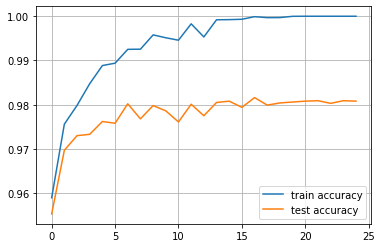

Total time: 163.08661556243896 seconds

Training accuracy list: [0.95895    0.9756     0.97983333 0.98475    0.98885    0.98938333
 0.99251667 0.99255    0.99578333 0.99513333 0.99458333 0.99828333
 0.99531667 0.9992     0.99923333 0.99931667 0.9999     0.99968333
 0.9997     0.99998333 1.         1.         1.         1.
 1.        ]
Training accuracy (Mean +/- Std): 99.35 (+/- 0.02)


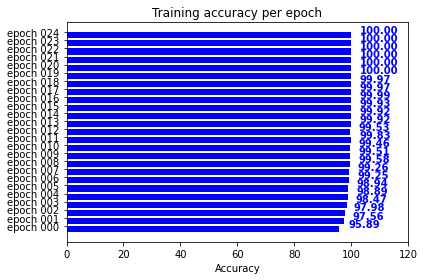


Test accuracy list: [0.9553 0.9697 0.973  0.9733 0.9762 0.9758 0.9802 0.9768 0.9798 0.9786
 0.9761 0.9801 0.9775 0.9805 0.9808 0.9794 0.9816 0.9799 0.9804 0.9806
 0.9808 0.9809 0.9803 0.9809 0.9808]
Test accuracy (Mean +/- Std): 97.76 (+/- 0.01)


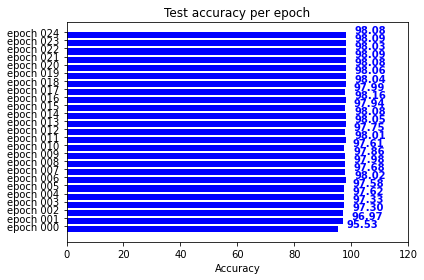


Epoch time list: [  6.18222117  12.50676441  18.87936997  25.28004169  31.88220525
  38.38206697  44.81065536  51.39714336  57.87160397  64.34665203
  71.02002621  77.52235126  84.08347225  90.58645654  97.00138259
 103.48406744 109.94400048 116.61210418 123.25231957 129.88322377
 136.39332128 143.04282904 149.56449699 156.24154139 162.89052033]
Epoch time (Mean +/- Std): 84.12 (+/- 94.21)


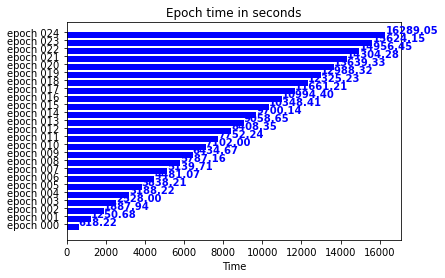

In [22]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.1, epochs=25, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

### Using **3 dense layers** with learning_rate=0.1, activation function = RELU, minibatches with batchsize=32, shuffle=True

In [23]:
dense_output_units=[100, 200, 300]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=25, dense_output_units=dense_output_units, activation_function=activation_function, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=784, output_units=100, learning_rate=0.1)
		RELU()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		RELU()
		Dense(input_units=200, output_units=300, learning_rate=0.1)
		RELU()
		Dense(input_units=300, output_units=10, learning_rate=0.1)


Epoch 24
Training accuracy: 100.00%
Test accuracy: 98.23%
Epoch's processing time: 260.26 seconds


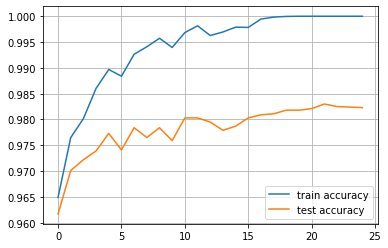

Total time: 260.4751946926117 seconds

Training accuracy list: [0.96488333 0.97648333 0.98016667 0.98603333 0.98968333 0.98838333
 0.99263333 0.99408333 0.99573333 0.99395    0.99683333 0.99815
 0.99626667 0.99695    0.99788333 0.99783333 0.99945    0.99983333
 0.99996667 1.         1.         1.         1.         1.
 1.        ]
Training accuracy (Mean +/- Std): 99.38 (+/- 0.02)


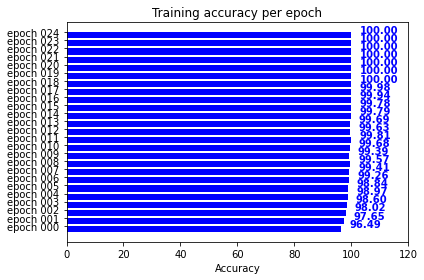


Test accuracy list: [0.9617 0.9701 0.9722 0.9739 0.9773 0.9741 0.9784 0.9765 0.9784 0.9759
 0.9803 0.9803 0.9795 0.9779 0.9787 0.9803 0.9809 0.9811 0.9818 0.9818
 0.9821 0.983  0.9825 0.9824 0.9823]
Test accuracy (Mean +/- Std): 97.81 (+/- 0.01)


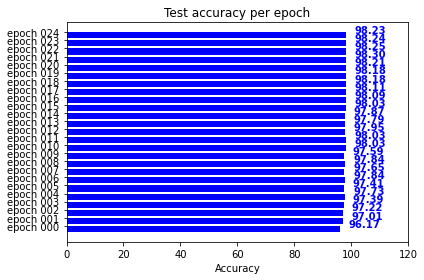


Epoch time list: [ 10.631356    21.02129269  31.85380769  42.99791765  53.17925811
  63.50741482  73.82425523  84.33839393  94.62079477 104.9782238
 115.02064204 125.37629151 135.83136916 146.09077001 156.32458663
 166.78390479 176.99657393 187.30155444 197.78288579 208.20485497
 218.64560771 229.10160637 239.32129359 250.01558733 260.25565314]
Epoch time (Mean +/- Std): 135.76 (+/- 149.52)


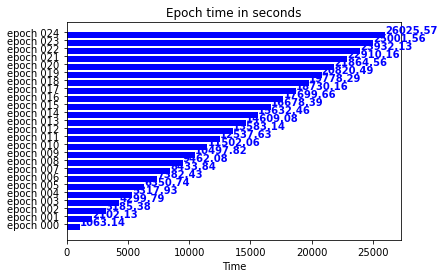

In [24]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.1, epochs=25, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

### Using **4 dense layers** with learning_rate=0.1, activation function = RELU, minibatches with batchsize=32, shuffle=True

In [25]:
dense_output_units=[100, 200, 300, 400]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=25, dense_output_units=dense_output_units, activation_function=activation_function, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=784, output_units=100, learning_rate=0.1)
		RELU()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		RELU()
		Dense(input_units=200, output_units=300, learning_rate=0.1)
		RELU()
		Dense(input_units=300, output_units=400, learning_rate=0.1)
		RELU()
		Dense(input_units=400, output_units=10, learning_rate=0.1)


Epoch 24
Training accuracy: 99.89%
Test accuracy: 97.94%
Epoch's processing time: 420.14 seconds


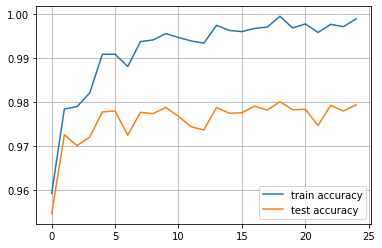

Total time: 420.33929228782654 seconds

Training accuracy list: [0.95926667 0.97846667 0.97898333 0.9821     0.9909     0.99091667
 0.98811667 0.99376667 0.99416667 0.9956     0.99471667 0.99393333
 0.99343333 0.99748333 0.99633333 0.99605    0.99678333 0.99708333
 0.99955    0.99688333 0.9978     0.99586667 0.99771667 0.99716667
 0.99895   ]
Training accuracy (Mean +/- Std): 99.21 (+/- 0.02)


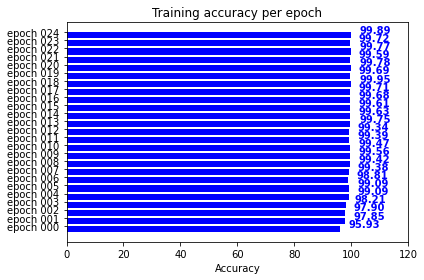


Test accuracy list: [0.9546 0.9726 0.9701 0.9721 0.9778 0.978  0.9725 0.9777 0.9774 0.9788
 0.9768 0.9744 0.9737 0.9788 0.9775 0.9776 0.9791 0.9782 0.9801 0.9783
 0.9784 0.9747 0.9793 0.978  0.9794]
Test accuracy (Mean +/- Std): 97.58 (+/- 0.01)


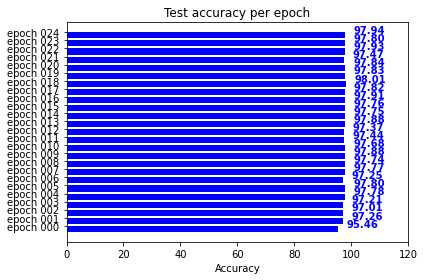


Epoch time list: [ 16.68996811  33.43159413  50.25383449  67.2276957   84.27772808
 101.78006244 118.59993649 135.15320778 151.65422535 168.153404
 184.62996101 201.09225821 217.66362953 234.02391481 250.8960228
 267.55333591 284.45420241 301.40828753 318.62244964 335.5905571
 352.47953033 369.09572124 385.95319986 402.82575512 420.13769794]
Epoch time (Mean +/- Std): 218.15 (+/- 241.71)


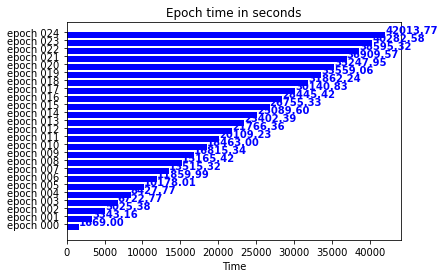

In [26]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.1, epochs=25, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

### Using **5 dense layers** with learning_rate=0.1, activation function = RELU, minibatches with batchsize=32, shuffle=True

In [27]:
dense_output_units=[100, 200, 300, 400, 500]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=25, dense_output_units=dense_output_units, activation_function=activation_function, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=784, output_units=100, learning_rate=0.1)
		RELU()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		RELU()
		Dense(input_units=200, output_units=300, learning_rate=0.1)
		RELU()
		Dense(input_units=300, output_units=400, learning_rate=0.1)
		RELU()
		Dense(input_units=400, output_units=500, learning_rate=0.1)
		RELU()
		Dense(input_units=500, output_units=10, learning_rate=0.1)


Epoch 24
Training accuracy: 99.89%
Test accuracy: 98.09%
Epoch's processing time: 665.13 seconds


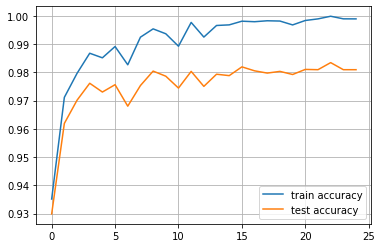

Total time: 665.3411335945129 seconds

Training accuracy list: [0.93516667 0.97111667 0.9796     0.98671667 0.9851     0.9891
 0.98263333 0.9924     0.99533333 0.9936     0.9892     0.99761667
 0.99243333 0.99653333 0.99675    0.99805    0.99786667 0.9982
 0.9981     0.99673333 0.9983     0.99886667 0.9998     0.99888333
 0.99886667]
Training accuracy (Mean +/- Std): 99.07 (+/- 0.03)


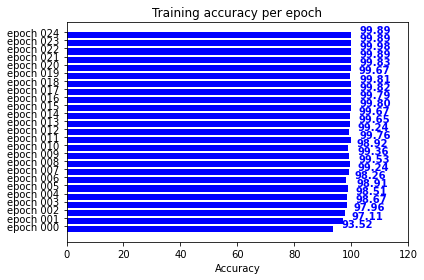


Test accuracy list: [0.9299 0.9619 0.9701 0.9761 0.973  0.9756 0.968  0.9753 0.9804 0.9786
 0.9744 0.9803 0.975  0.9793 0.9788 0.9819 0.9805 0.9797 0.9803 0.9792
 0.981  0.9809 0.9834 0.9809 0.9809]
Test accuracy (Mean +/- Std): 97.54 (+/- 0.02)


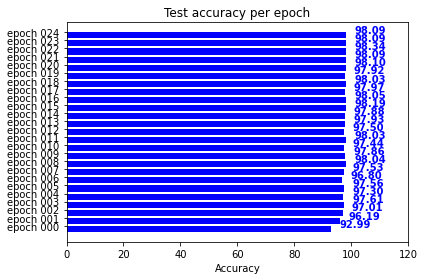


Epoch time list: [ 27.0457747   53.54553819  79.76910377 105.86869383 132.23777747
 158.57858801 185.457798   212.02168632 238.61587501 265.37819076
 292.28859711 319.47123075 346.4178586  373.23696446 399.99719095
 426.77485371 453.06966758 479.55777335 505.93619633 532.42497396
 558.71077299 584.86986709 611.63713789 638.6041162  665.12517309]
Epoch time (Mean +/- Std): 345.87 (+/- 384.11)


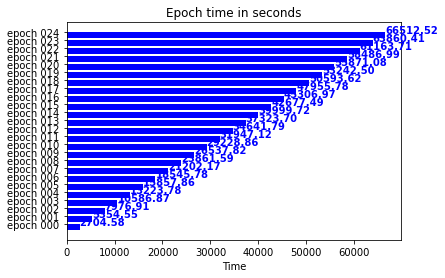

In [28]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.1, epochs=25, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

## Best number of dense layers

* Highest test accuracy (mean)

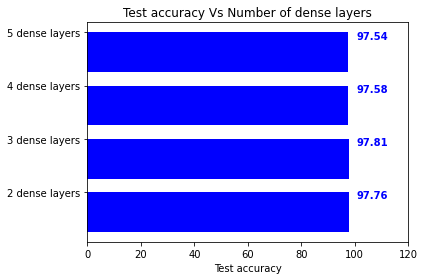

In [29]:
labels = ['2 dense layers', '3 dense layers', '4 dense layers', '5 dense layers']
plot_horizontal_bar(labels, test_accuracy_list, xlabel='Test accuracy', ylabel='', title='Test accuracy Vs Number of dense layers', use_xlim=True)

In [0]:
test_accuracy_list = []

## Testing different learning rates

* Using 3 dense layers with **learning_rate=0.1**, activation function = RELU, minibatches with batchsize=32, shuffle=True

* Using 3 dense layers with **learning_rate=0.01**, activation function = RELU, minibatches with batchsize=32, shuffle=True

* Using 3 dense layers with **learning_rate=0.001**, activation function = RELU, minibatches with batchsize=32, shuffle=True

* Using 3 dense layers with **learning_rate=0.0001**, activation function = RELU, minibatches with batchsize=32, shuffle=True

In [31]:
dense_output_units=[100, 200, 300]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=25, dense_output_units=dense_output_units, activation_function=activation_function, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=784, output_units=100, learning_rate=0.1)
		RELU()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		RELU()
		Dense(input_units=200, output_units=300, learning_rate=0.1)
		RELU()
		Dense(input_units=300, output_units=10, learning_rate=0.1)


### Using 3 dense layers with **learning_rate=0.1**, activation function = RELU, minibatches with batchsize=32, shuffle=True

Epoch 24
Training accuracy: 100.00%
Test accuracy: 98.21%
Epoch's processing time: 253.12 seconds


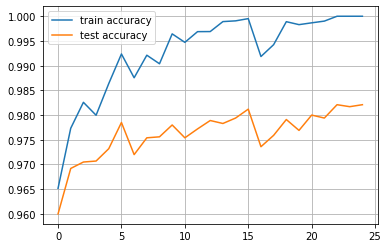

Total time: 253.31991744041443 seconds

Training accuracy list: [0.96518333 0.97733333 0.98258333 0.97996667 0.98638333 0.99236667
 0.98755    0.99211667 0.99038333 0.99643333 0.99471667 0.99688333
 0.9969     0.99891667 0.99906667 0.99951667 0.99185    0.99425
 0.9989     0.9983     0.99866667 0.99901667 1.         1.
 1.        ]
Training accuracy (Mean +/- Std): 99.27 (+/- 0.02)


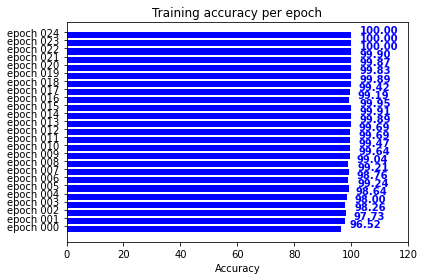


Test accuracy list: [0.96   0.9692 0.9705 0.9707 0.9732 0.9785 0.972  0.9754 0.9756 0.978
 0.9754 0.9772 0.9789 0.9783 0.9794 0.9812 0.9736 0.9759 0.9791 0.9769
 0.98   0.9794 0.9821 0.9817 0.9821]
Test accuracy (Mean +/- Std): 97.62 (+/- 0.01)


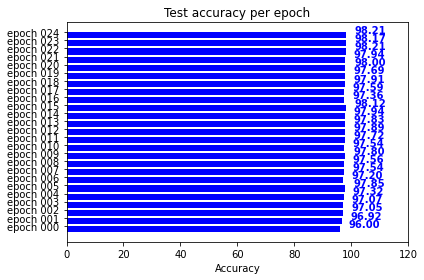


Epoch time list: [  9.84338474  19.86899281  29.50751615  39.76091647  49.73451614
  59.71874857  69.72187424  79.94912434  89.99197364 100.12398267
 110.25490379 120.39776516 130.50284815 140.45425677 150.41947722
 160.37884378 170.75096273 180.86036205 191.2673614  201.51425791
 211.72371626 222.0244453  232.45394397 242.74318862 253.11525178]
Epoch time (Mean +/- Std): 130.68 (+/- 146.08)


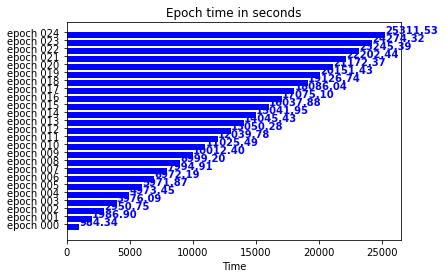

In [32]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.1, epochs=25, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

### Using 3 dense layers with **learning_rate=0.01**, activation function = RELU, minibatches with batchsize=32, shuffle=True

Epoch 24
Training accuracy: 100.00%
Test accuracy: 98.22%
Epoch's processing time: 252.72 seconds


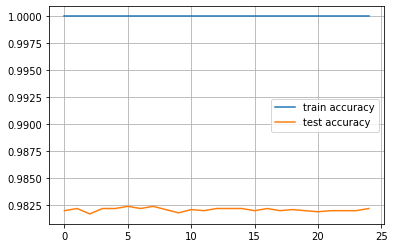

Total time: 252.93451595306396 seconds

Training accuracy list: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]
Training accuracy (Mean +/- Std): 100.00 (+/- 0.00)


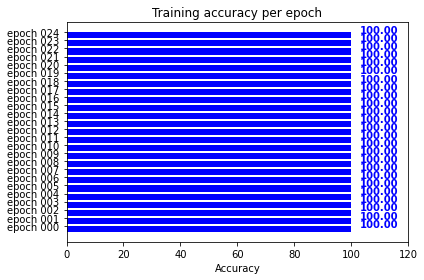


Test accuracy list: [0.982  0.9822 0.9817 0.9822 0.9822 0.9824 0.9822 0.9824 0.9821 0.9818
 0.9821 0.982  0.9822 0.9822 0.9822 0.982  0.9822 0.982  0.9821 0.982
 0.9819 0.982  0.982  0.982  0.9822]
Test accuracy (Mean +/- Std): 98.21 (+/- 0.00)


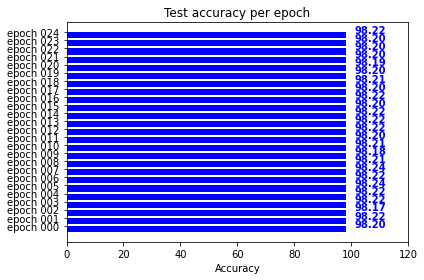


Epoch time list: [  9.84925747  19.98415923  30.47136664  41.02244473  51.10347652
  61.31890273  71.53948116  81.79437184  91.87397099 102.20658803
 112.30267358 122.20969701 132.13911533 142.2501359  152.17111635
 162.2526319  172.3259933  182.36124682 192.4529357  202.66569567
 212.81771016 222.96365571 232.83726263 242.70406604 252.72488809]
Epoch time (Mean +/- Std): 131.93 (+/- 145.76)


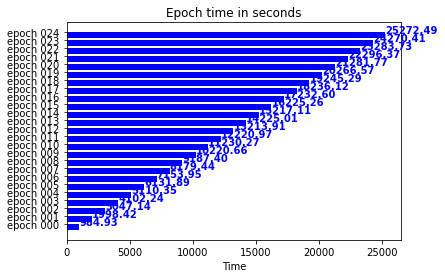

In [33]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.01, epochs=25, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

### Using 3 dense layers with **learning_rate=0.001**, activation function = RELU, minibatches with batchsize=32, shuffle=True

Epoch 24
Training accuracy: 100.00%
Test accuracy: 98.23%
Epoch's processing time: 253.04 seconds


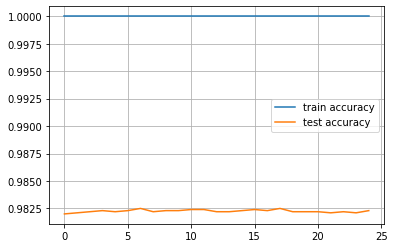

Total time: 253.24374675750732 seconds

Training accuracy list: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]
Training accuracy (Mean +/- Std): 100.00 (+/- 0.00)


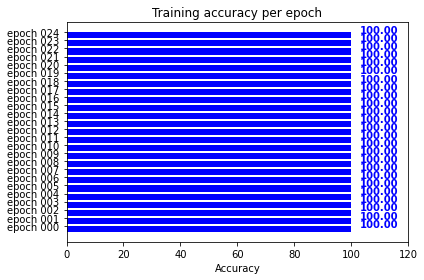


Test accuracy list: [0.982  0.9821 0.9822 0.9823 0.9822 0.9823 0.9825 0.9822 0.9823 0.9823
 0.9824 0.9824 0.9822 0.9822 0.9823 0.9824 0.9823 0.9825 0.9822 0.9822
 0.9822 0.9821 0.9822 0.9821 0.9823]
Test accuracy (Mean +/- Std): 98.23 (+/- 0.00)


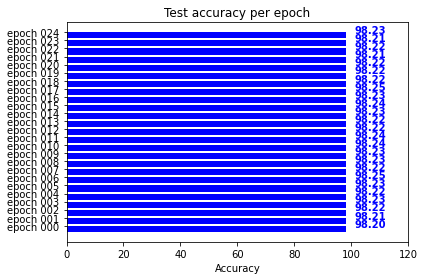


Epoch time list: [  9.82812023  20.01041293  29.84471989  40.00572109  50.16585732
  60.22014856  70.28159165  80.27398229  90.23059249 100.70266294
 110.65970087 120.72274613 130.81421661 140.92195034 150.76857114
 160.86254239 171.00499034 181.32758975 191.81676936 202.09072542
 212.44685078 222.74793816 232.78120279 242.97959685 253.0373981 ]
Epoch time (Mean +/- Std): 131.06 (+/- 146.17)


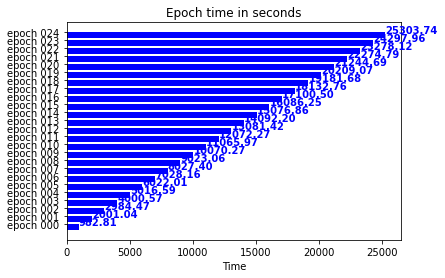

In [34]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=25, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

### Using 3 dense layers with **learning_rate=0.0001**, activation function = RELU, minibatches with batchsize=32, shuffle=True

Epoch 24
Training accuracy: 100.00%
Test accuracy: 98.21%
Epoch's processing time: 254.87 seconds


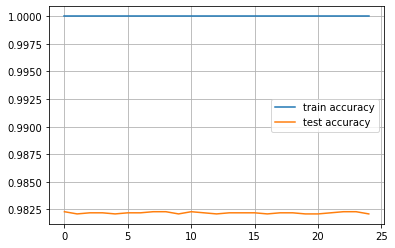

Total time: 255.08509516716003 seconds

Training accuracy list: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]
Training accuracy (Mean +/- Std): 100.00 (+/- 0.00)


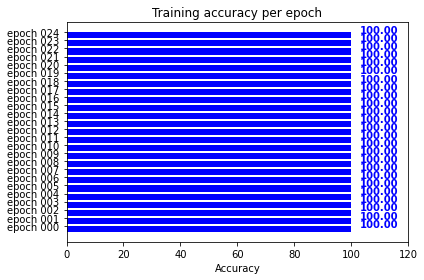


Test accuracy list: [0.9823 0.9821 0.9822 0.9822 0.9821 0.9822 0.9822 0.9823 0.9823 0.9821
 0.9823 0.9822 0.9821 0.9822 0.9822 0.9822 0.9821 0.9822 0.9822 0.9821
 0.9821 0.9822 0.9823 0.9823 0.9821]
Test accuracy (Mean +/- Std): 98.22 (+/- 0.00)


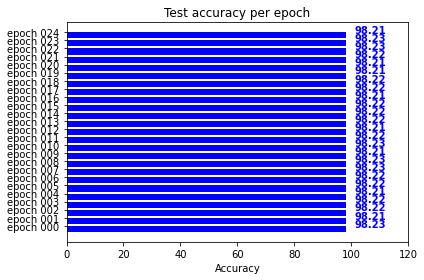


Epoch time list: [  9.98505592  20.04304481  29.94535661  40.34061861  50.46364689
  60.74937057  70.91224098  81.04957581  91.53433228 101.75769043
 111.9460175  122.42401624 132.81556559 142.9597733  153.00173879
 163.63790822 174.14423752 184.30080032 194.42329526 204.56615543
 214.65926743 224.81087089 234.86600542 244.82726645 254.87252188]
Epoch time (Mean +/- Std): 132.60 (+/- 147.74)


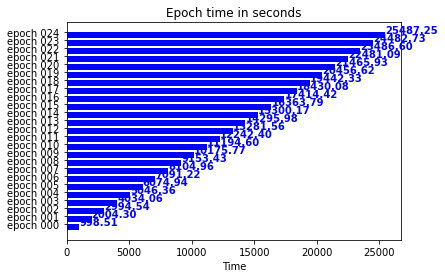

In [35]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.0001, epochs=25, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

## Best learning rate

* Highest test accuracy (mean)

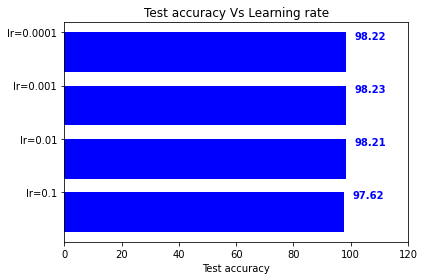

In [36]:
labels = ['lr=0.1', 'lr=0.01', 'lr=0.001', 'lr=0.0001']
plot_horizontal_bar(labels, test_accuracy_list, xlabel='Test accuracy', ylabel='', title='Test accuracy Vs Learning rate', use_xlim=True)

In [0]:
test_accuracy_list = []

## Testing different batch size

* Using 3 dense layers with learning_rate=0.001, activation function = RELU, minibatches with **batchsize=8**, shuffle=True

* Using 3 dense layers with learning_rate=0.001, activation function = RELU, minibatches with **batchsize=16**, shuffle=True

* Using 3 dense layers with learning_rate=0.001, activation function = RELU, minibatches with **batchsize=32**, shuffle=True

* Using 3 dense layers with learning_rate=0.001, activation function = RELU, minibatches with **batchsize=64**, shuffle=True

* Using 3 dense layers with learning_rate=0.001, activation function = RELU, minibatches with **batchsize=128**, shuffle=True

In [38]:
dense_output_units=[100, 200, 300]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=25, dense_output_units=dense_output_units, activation_function=activation_function, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=784, output_units=100, learning_rate=0.1)
		RELU()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		RELU()
		Dense(input_units=200, output_units=300, learning_rate=0.1)
		RELU()
		Dense(input_units=300, output_units=10, learning_rate=0.1)


### Using 3 dense layers with learning_rate=0.001, activation function = RELU, minibatches with **batchsize=8**, shuffle=True

Epoch 24
Training accuracy: 99.59%
Test accuracy: 97.88%
Epoch's processing time: 535.26 seconds


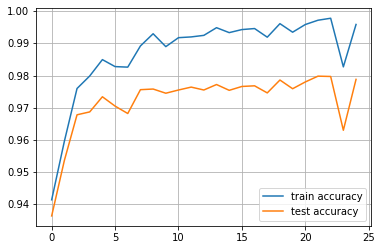

Total time: 535.4615988731384 seconds

Training accuracy list: [0.9414     0.95955    0.97596667 0.97985    0.98493333 0.98276667
 0.9826     0.98918333 0.99296667 0.98896667 0.99175    0.99198333
 0.99246667 0.99485    0.99331667 0.99426667 0.99458333 0.9919
 0.9961     0.99345    0.99583333 0.99716667 0.99778333 0.98268333
 0.99585   ]
Training accuracy (Mean +/- Std): 98.73 (+/- 0.03)


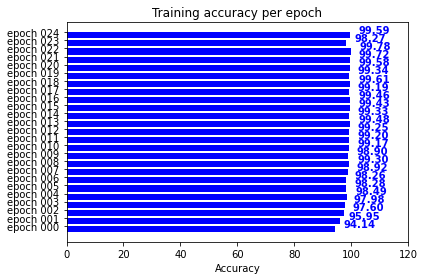


Test accuracy list: [0.9364 0.9536 0.9678 0.9687 0.9734 0.9705 0.9682 0.9756 0.9758 0.9745
 0.9755 0.9764 0.9755 0.9772 0.9754 0.9766 0.9768 0.9746 0.9786 0.9759
 0.978  0.9798 0.9797 0.963  0.9788]
Test accuracy (Mean +/- Std): 97.23 (+/- 0.02)


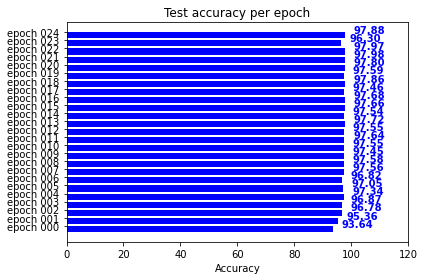


Epoch time list: [ 21.89494944  43.92465186  65.78646278  87.59963202 109.01198149
 130.47319007 152.10235095 173.61642957 194.9253366  216.07930946
 238.45771194 259.86700153 280.97887993 302.21391702 323.40607047
 344.54568624 365.75620103 387.06899738 408.05653167 429.32638192
 450.62332106 471.74287248 493.09506869 514.14699602 535.26429844]
Epoch time (Mean +/- Std): 280.00 (+/- 308.11)


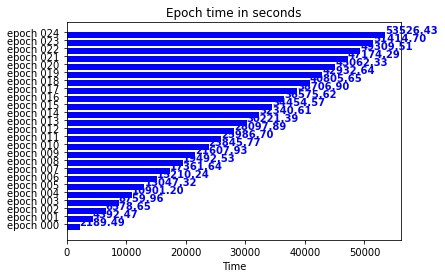

In [39]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=25, dense_output_units=dense_output_units, batchsize=8, shuffle=True)

### Using 3 dense layers with learning_rate=0.001, activation function = RELU, minibatches with **batchsize=16**, shuffle=True

Epoch 24
Training accuracy: 100.00%
Test accuracy: 98.29%
Epoch's processing time: 336.74 seconds


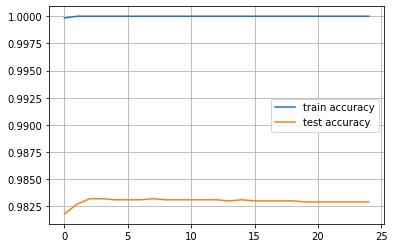

Total time: 336.9531624317169 seconds

Training accuracy list: [0.99983333 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.        ]
Training accuracy (Mean +/- Std): 100.00 (+/- 0.00)


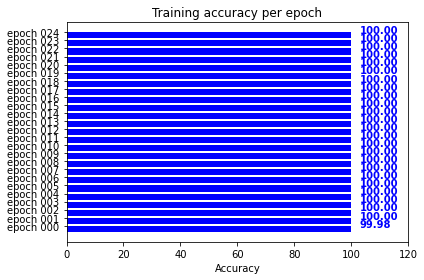


Test accuracy list: [0.9818 0.9827 0.9832 0.9832 0.9831 0.9831 0.9831 0.9832 0.9831 0.9831
 0.9831 0.9831 0.9831 0.983  0.9831 0.983  0.983  0.983  0.983  0.9829
 0.9829 0.9829 0.9829 0.9829 0.9829]
Test accuracy (Mean +/- Std): 98.30 (+/- 0.00)


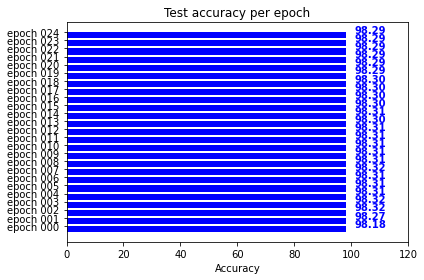


Epoch time list: [ 13.68861461  27.59944296  40.84999323  54.3945868   67.90971279
  81.52886534  94.98120141 108.51986456 121.58194518 134.98095775
 148.21657705 161.92619109 175.72289228 189.54459667 203.21546698
 216.90895057 230.58315945 243.65069938 256.96954966 270.13284683
 283.34194493 296.54139495 309.66447973 322.9732163  336.74111986]
Epoch time (Mean +/- Std): 175.69 (+/- 194.19)


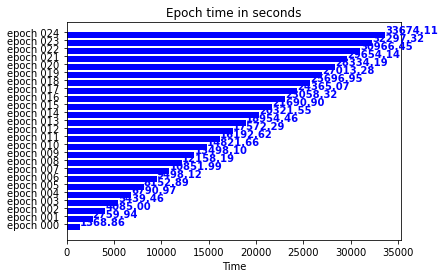

In [40]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=25, dense_output_units=dense_output_units, batchsize=16, shuffle=True)

### Using 3 dense layers with learning_rate=0.001, activation function = RELU, minibatches with **batchsize=32**, shuffle=True

Epoch 24
Training accuracy: 100.00%
Test accuracy: 98.30%
Epoch's processing time: 244.39 seconds


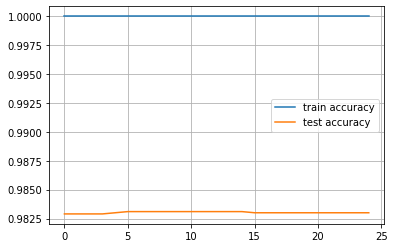

Total time: 244.60120248794556 seconds

Training accuracy list: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]
Training accuracy (Mean +/- Std): 100.00 (+/- 0.00)


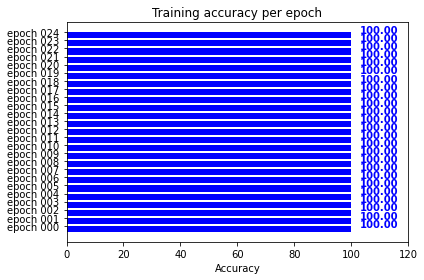


Test accuracy list: [0.9829 0.9829 0.9829 0.9829 0.983  0.9831 0.9831 0.9831 0.9831 0.9831
 0.9831 0.9831 0.9831 0.9831 0.9831 0.983  0.983  0.983  0.983  0.983
 0.983  0.983  0.983  0.983  0.983 ]
Test accuracy (Mean +/- Std): 98.30 (+/- 0.00)


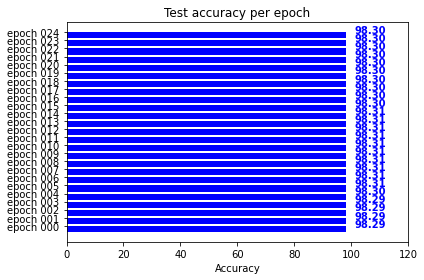


Epoch time list: [  9.37543106  19.04600668  28.69911528  38.26267672  48.19703674
  57.92052817  67.78172207  77.64123988  87.13520861  96.96736908
 106.56408    116.19850707 125.86323667 135.6426754  145.31352329
 155.0533371  164.54504776 174.49510503 184.31745315 194.38257813
 204.22224736 214.18676949 224.22107959 234.25614977 244.38615179]
Epoch time (Mean +/- Std): 126.19 (+/- 140.83)


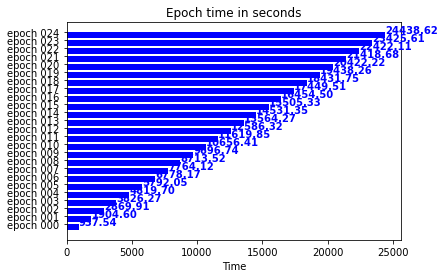

In [41]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=25, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

### Using 3 dense layers with learning_rate=0.001, activation function = RELU, minibatches with **batchsize=64**, shuffle=True

Epoch 24
Training accuracy: 100.00%
Test accuracy: 98.30%
Epoch's processing time: 186.37 seconds


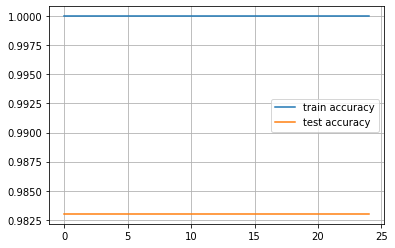

Total time: 186.5803279876709 seconds

Training accuracy list: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]
Training accuracy (Mean +/- Std): 100.00 (+/- 0.00)


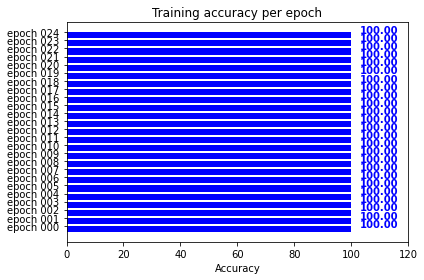


Test accuracy list: [0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983
 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983
 0.983]
Test accuracy (Mean +/- Std): 98.30 (+/- 0.00)


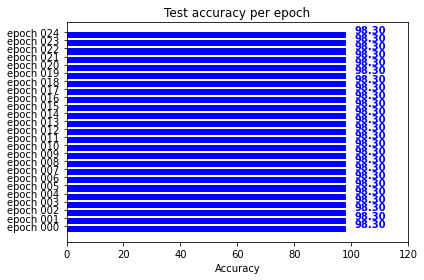


Epoch time list: [  7.16124511  14.62784028  22.05604172  29.51714754  36.84336925
  44.11352396  51.49921274  59.06997371  66.80651879  74.55313873
  82.08674431  89.46259451  96.91728091 104.31943154 111.67964959
 119.28452539 126.72104979 134.37829304 141.94526362 149.54352117
 157.00672317 164.53726912 171.55109572 179.01404858 186.36729884]
Epoch time (Mean +/- Std): 96.84 (+/- 108.00)


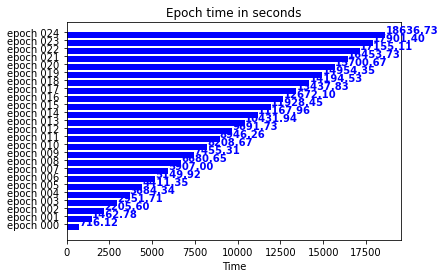

In [42]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=25, dense_output_units=dense_output_units, batchsize=64, shuffle=True)

### Using 3 dense layers with learning_rate=0.001, activation function = RELU, minibatches with **batchsize=128**, shuffle=True

Epoch 24
Training accuracy: 100.00%
Test accuracy: 98.30%
Epoch's processing time: 162.02 seconds


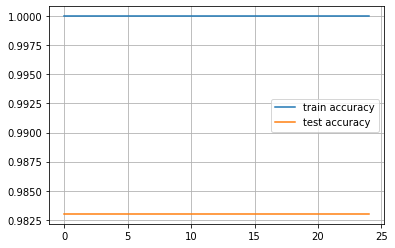

Total time: 162.22543048858643 seconds

Training accuracy list: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]
Training accuracy (Mean +/- Std): 100.00 (+/- 0.00)


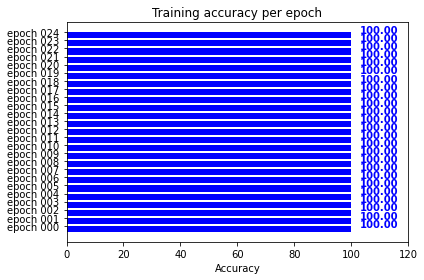


Test accuracy list: [0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983
 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983
 0.983]
Test accuracy (Mean +/- Std): 98.30 (+/- 0.00)


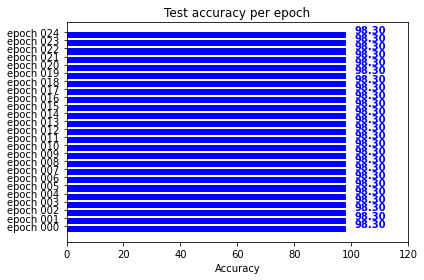


Epoch time list: [  6.28783774  12.67141271  19.08722353  25.59254503  32.01675487
  38.54030752  44.90641212  51.35838056  57.802706    65.35454559
  72.7294085   79.03442383  85.59010792  91.91387415  98.28953362
 104.6386683  110.9103601  117.33452225 123.74019122 130.14574432
 136.46710658 142.90604568 149.24212074 155.66518617 162.01663923]
Epoch time (Mean +/- Std): 84.57 (+/- 94.01)


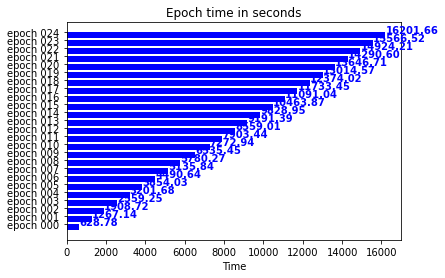

In [43]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=25, dense_output_units=dense_output_units, batchsize=128, shuffle=True)

## Best batch size

* Highest test accuracy (mean)

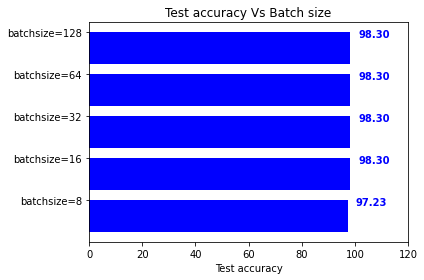

In [44]:
labels = ['batchsize=8', 'batchsize=16', 'batchsize=32', 'batchsize=64', 'batchsize=128']
plot_horizontal_bar(labels, test_accuracy_list, xlabel='Test accuracy', ylabel='', title='Test accuracy Vs Batch size', use_xlim=True)

In [0]:
test_accuracy_list = []

## Testing different activation functions

* Using 3 dense layers with learning_rate=0.001, **activation function = RELU**, minibatches with batchsize=128, shuffle=True

* Using 3 dense layers with learning_rate=0.001, **activation function = LEAKY_RELU**, minibatches with batchsize=128, shuffle=True

* Using 3 dense layers with learning_rate=0.001, **activation function = TANH**, minibatches with batchsize=128, shuffle=True

* Using 3 dense layers with learning_rate=0.001, **activation function = SIGMOID**, minibatches with batchsize=128, shuffle=True

### Using 3 dense layers with learning_rate=0.001, **activation function = RELU**, minibatches with batchsize=128, shuffle=True

In [78]:
dense_output_units=[100, 200, 300]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=25, dense_output_units=dense_output_units, activation_function=ActivationFunction.RELU, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=784, output_units=100, learning_rate=0.1)
		RELU()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		RELU()
		Dense(input_units=200, output_units=300, learning_rate=0.1)
		RELU()
		Dense(input_units=300, output_units=10, learning_rate=0.1)


Epoch 24
Training accuracy: 99.97%
Test accuracy: 97.97%
Epoch's processing time: 170.21 seconds


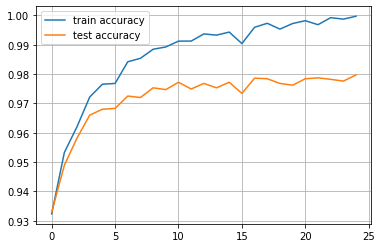

Total time: 170.40711975097656 seconds

Training accuracy list: [0.93233333 0.95326667 0.96206667 0.97216667 0.97653333 0.9768
 0.98418333 0.98536667 0.98845    0.98923333 0.99121667 0.99123333
 0.99366667 0.99326667 0.9943     0.99038333 0.99593333 0.9973
 0.99531667 0.99721667 0.99818333 0.99681667 0.99921667 0.99871667
 0.9997    ]
Training accuracy (Mean +/- Std): 98.61 (+/- 0.03)


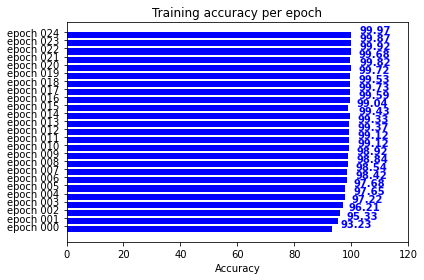


Test accuracy list: [0.9329 0.9489 0.9582 0.966  0.968  0.9683 0.9725 0.972  0.9753 0.9747
 0.9772 0.9749 0.9768 0.9753 0.9772 0.9734 0.9786 0.9784 0.9768 0.9762
 0.9784 0.9787 0.9782 0.9776 0.9797]
Test accuracy (Mean +/- Std): 97.18 (+/- 0.02)


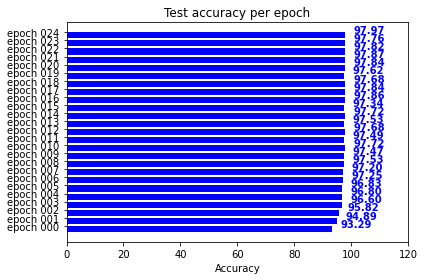


Epoch time list: [  6.61765003  13.55134082  20.40735126  27.1698482   33.97174907
  40.78558612  47.51741242  54.2937119   61.10253763  68.08852577
  75.09836483  82.11210918  89.02391386  95.82757616 102.56754637
 109.30307817 116.0594697  122.7726686  129.50332379 136.28892231
 142.96107554 149.64294219 156.41662455 163.39913297 170.20795608]
Epoch time (Mean +/- Std): 88.59 (+/- 98.30)


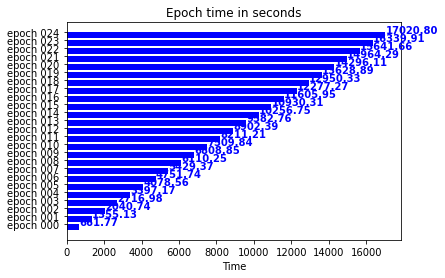

In [79]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=25, dense_output_units=dense_output_units, batchsize=128, shuffle=True)

### Using 3 dense layers with learning_rate=0.001, **activation function = LEAKY_RELU**, minibatches with batchsize=128, shuffle=True

In [80]:
dense_output_units=[100, 200, 300]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=25, dense_output_units=dense_output_units, activation_function=ActivationFunction.LEAKY_RELU, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=784, output_units=100, learning_rate=0.1)
		LEAKY_RELU()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		LEAKY_RELU()
		Dense(input_units=200, output_units=300, learning_rate=0.1)
		LEAKY_RELU()
		Dense(input_units=300, output_units=10, learning_rate=0.1)


Epoch 24
Training accuracy: 99.97%
Test accuracy: 97.97%
Epoch's processing time: 175.28 seconds


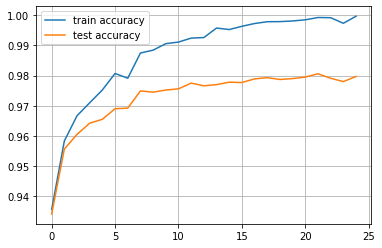

Total time: 175.47428059577942 seconds

Training accuracy list: [0.93556667 0.95831667 0.96666667 0.97098333 0.97523333 0.9807
 0.97911667 0.98748333 0.98843333 0.99058333 0.99111667 0.99243333
 0.99261667 0.99576667 0.99526667 0.99635    0.99726667 0.99786667
 0.9979     0.99811667 0.9985     0.99926667 0.9992     0.99735
 0.99968333]
Training accuracy (Mean +/- Std): 98.73 (+/- 0.03)


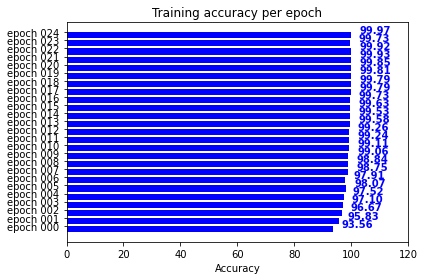


Test accuracy list: [0.9341 0.9556 0.9605 0.9642 0.9655 0.969  0.9692 0.9749 0.9745 0.9752
 0.9756 0.9775 0.9766 0.977  0.9778 0.9777 0.9789 0.9793 0.9787 0.979
 0.9795 0.9806 0.9791 0.978  0.9797]
Test accuracy (Mean +/- Std): 97.27 (+/- 0.02)


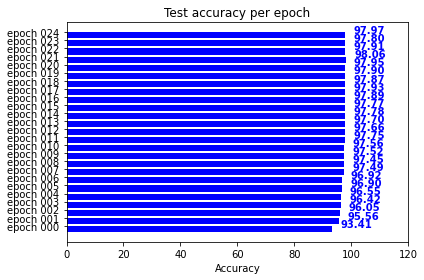


Epoch time list: [  6.75349617  13.77869916  20.73511434  27.78406262  34.81580305
  41.86356664  48.8217895   55.80535126  62.721416    69.71304703
  76.71141243  83.91147566  90.86360121  97.851161   104.95633388
 111.94253492 118.97687268 125.85743189 132.92721343 139.90395761
 146.94922924 154.14786148 161.21248937 168.23510289 175.27549076]
Epoch time (Mean +/- Std): 90.90 (+/- 101.22)


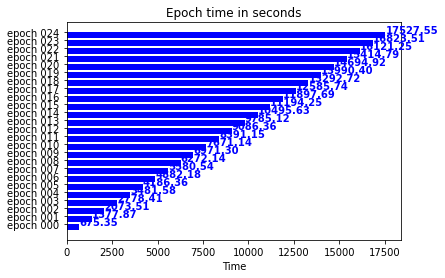

In [81]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=25, dense_output_units=dense_output_units, batchsize=128, shuffle=True)


### Using 3 dense layers with learning_rate=0.001, **activation function = TANH**, minibatches with batchsize=128, shuffle=True

In [82]:
dense_output_units=[100, 200, 300]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=25, dense_output_units=dense_output_units, activation_function=ActivationFunction.TANH, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=784, output_units=100, learning_rate=0.1)
		TANH()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		TANH()
		Dense(input_units=200, output_units=300, learning_rate=0.1)
		TANH()
		Dense(input_units=300, output_units=10, learning_rate=0.1)


Epoch 24
Training accuracy: 99.88%
Test accuracy: 97.73%
Epoch's processing time: 323.53 seconds


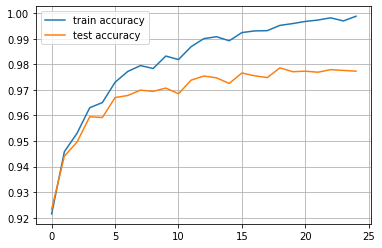

Total time: 323.73187804222107 seconds

Training accuracy list: [0.92153333 0.94583333 0.95305    0.96301667 0.96505    0.97296667
 0.9772     0.97948333 0.97835    0.98321667 0.98183333 0.9869
 0.99001667 0.99076667 0.98918333 0.99238333 0.99303333 0.99313333
 0.9952     0.9959     0.99673333 0.99728333 0.99815    0.99693333
 0.99876667]
Training accuracy (Mean +/- Std): 98.14 (+/- 0.04)


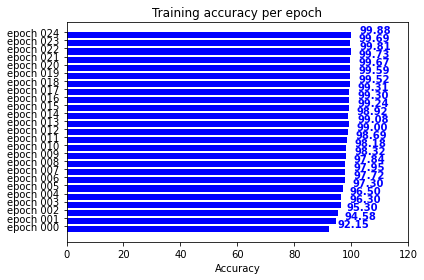


Test accuracy list: [0.9234 0.9441 0.9496 0.9595 0.9592 0.967  0.9678 0.9699 0.9694 0.9707
 0.9685 0.9738 0.9754 0.9747 0.9725 0.9766 0.9755 0.9748 0.9786 0.9771
 0.9773 0.9769 0.9779 0.9776 0.9773]
Test accuracy (Mean +/- Std): 96.86 (+/- 0.03)


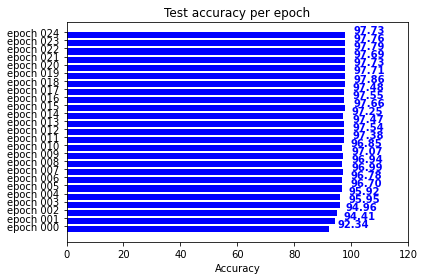


Epoch time list: [ 12.33430672  25.10645342  37.87669659  50.88472605  63.97745943
  76.82089543  89.90476489 102.85883069 115.74203706 128.65624118
 141.56836438 154.51708364 167.45879722 180.38813305 193.35184097
 206.37736559 219.40272665 232.4034183  245.45169687 258.44842958
 271.44179273 284.51510358 297.55877995 310.44126034 323.53037786]
Epoch time (Mean +/- Std): 167.64 (+/- 187.07)


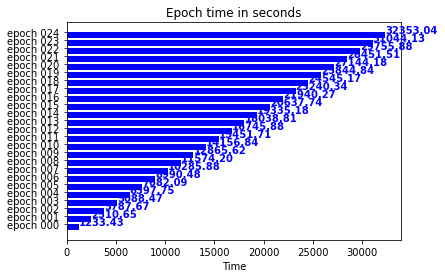

In [83]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=25, dense_output_units=dense_output_units, batchsize=128, shuffle=True)

### Using 3 dense layers with learning_rate=0.001, **activation function = SIGMOID**, minibatches with batchsize=128, shuffle=True

In [84]:
dense_output_units=[100, 200, 300]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=25, dense_output_units=dense_output_units, activation_function=ActivationFunction.SIGMOID, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=784, output_units=100, learning_rate=0.1)
		SIGMOID()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		SIGMOID()
		Dense(input_units=200, output_units=300, learning_rate=0.1)
		SIGMOID()
		Dense(input_units=300, output_units=10, learning_rate=0.1)


Epoch 24
Training accuracy: 95.90%
Test accuracy: 95.61%
Epoch's processing time: 281.15 seconds


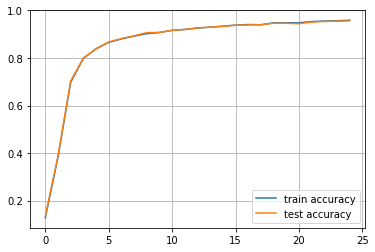

Total time: 281.33511233329773 seconds

Training accuracy list: [0.12775    0.38268333 0.69768333 0.7983     0.83893333 0.86588333
 0.88046667 0.8923     0.90246667 0.9075     0.91641667 0.92028333
 0.9259     0.92991667 0.93426667 0.93848333 0.94091667 0.93983333
 0.94801667 0.94811667 0.94845    0.9534     0.95563333 0.95693333
 0.959     ]
Training accuracy (Mean +/- Std): 85.64 (+/- 0.38)


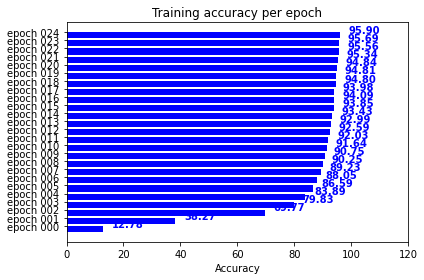


Test accuracy list: [0.1351 0.3883 0.7038 0.7999 0.839  0.8675 0.8819 0.8935 0.9069 0.9075
 0.917  0.92   0.9271 0.9299 0.9332 0.9379 0.9393 0.9405 0.9463 0.9463
 0.9446 0.9514 0.9537 0.9551 0.9561]
Test accuracy (Mean +/- Std): 85.69 (+/- 0.38)


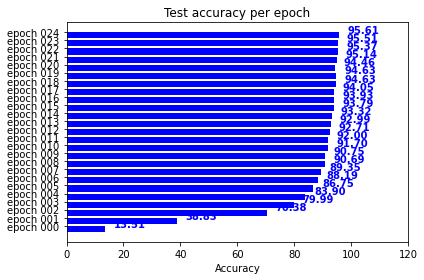


Epoch time list: [ 10.90663171  22.14657855  33.27095175  44.48169756  55.91119981
  67.29295754  78.34470868  89.43315721 100.7114985  112.12733984
 123.40054512 134.74490929 146.07050824 157.31590986 168.53624535
 179.74992108 190.98112774 202.16386223 213.34520841 224.56904173
 235.9283216  247.14396834 258.56601739 270.00065398 281.14920878]
Epoch time (Mean +/- Std): 145.93 (+/- 162.39)


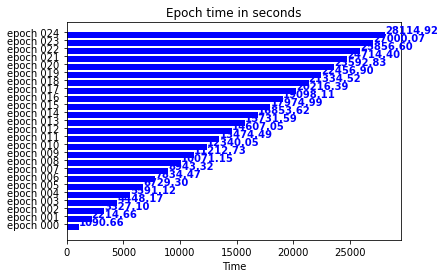

In [85]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=25, dense_output_units=dense_output_units, batchsize=128, shuffle=True)

## Best activation functions

* Highest test accuracy (mean)

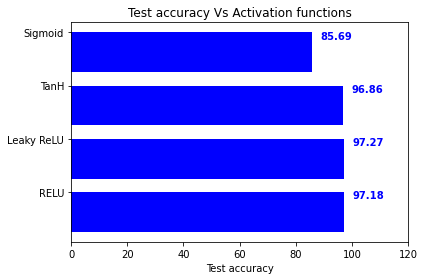

In [86]:
# ReLU layer, Leaky_ReLU, TanH(Hyperbolic tangent function), Sigmoid 
labels = ['RELU', 'Leaky ReLU', 'TanH', 'Sigmoid']
plot_horizontal_bar(labels, test_accuracy_list, xlabel='Test accuracy', ylabel='', title='Test accuracy Vs Activation functions', use_xlim=True)

## Conclusion: Best MLP model

### Best MLP model: Using 3 dense layers with learning_rate=0.001, **activation function = LEAKY_RELU**, minibatches with batchsize=128, shuffle=True

In [87]:
dense_output_units=[100, 200, 300]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=25, dense_output_units=dense_output_units, activation_function=ActivationFunction.LEAKY_RELU, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=784, output_units=100, learning_rate=0.1)
		LEAKY_RELU()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		LEAKY_RELU()
		Dense(input_units=200, output_units=300, learning_rate=0.1)
		LEAKY_RELU()
		Dense(input_units=300, output_units=10, learning_rate=0.1)


Epoch 24
Training accuracy: 99.96%
Test accuracy: 97.77%
Epoch's processing time: 175.66 seconds


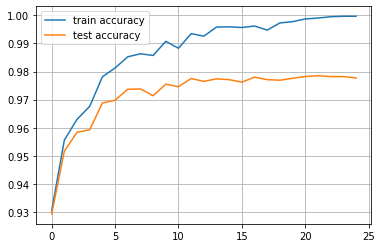

Total time: 175.86832690238953 seconds

Training accuracy list: [0.93055    0.95561667 0.96301667 0.96761667 0.9781     0.98126667
 0.98521667 0.9863     0.9857     0.99071667 0.98826667 0.99345
 0.99255    0.99578333 0.99586667 0.99563333 0.99615    0.99471667
 0.99726667 0.99771667 0.99866667 0.999      0.99945    0.99963333
 0.99961667]
Training accuracy (Mean +/- Std): 98.67 (+/- 0.03)


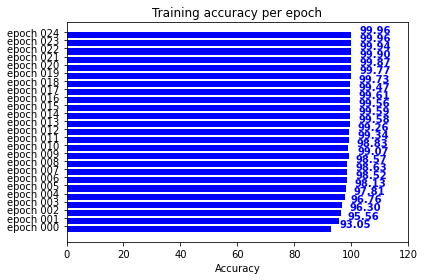


Test accuracy list: [0.9294 0.9517 0.9584 0.9593 0.9688 0.9698 0.9737 0.9738 0.9714 0.9755
 0.9746 0.9775 0.9765 0.9774 0.9771 0.9762 0.978  0.9771 0.9769 0.9776
 0.9782 0.9785 0.9782 0.9782 0.9777]
Test accuracy (Mean +/- Std): 97.17 (+/- 0.02)


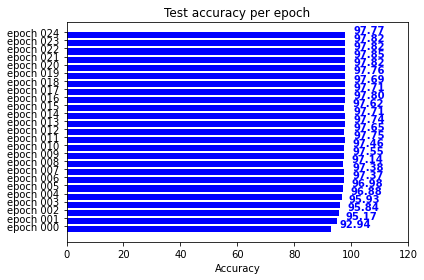


Epoch time list: [  6.70873713  13.70638657  20.87928867  27.88281822  34.82682037
  41.93468928  48.95642734  55.94598579  62.9701221   70.05299544
  77.03590918  84.1296556   91.31700945  98.45982623 105.46281171
 112.46881318 119.44007444 126.40539145 133.3888166  140.45503998
 147.41111732 154.46057582 161.60171413 168.69339871 175.66385531]
Epoch time (Mean +/- Std): 91.21 (+/- 101.54)


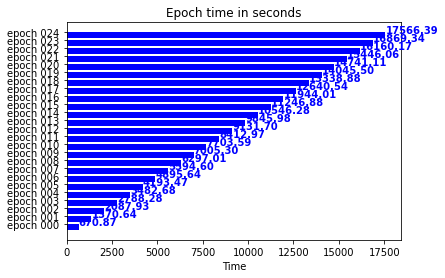

In [88]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=25, dense_output_units=dense_output_units, batchsize=128, shuffle=True)

**Reference:** 

https://towardsdatascience.com/cifar-10-image-classification-in-tensorflow-5b501f7dc77c

http://home.mit.bme.hu/~hadhazi/Oktatas/NN18/dem3/html_demo/CIFAR-10Demo.html

http://www.cs.nthu.edu.tw/~shwu/courses/ml/labs/11_NN_Regularization/11_NN_Regularization.html

https://towardsdatascience.com/building-neural-network-from-scratch-9c88535bf8e9

https://towardsdatascience.com/building-neural-network-from-scratch-9c88535bf8e9